In [1]:
import os
from tensorflow.python.keras.preprocessing import image
import time
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import time

### liste des paires de chemins images/GT

In [2]:
def im_seg_pairs():
    """renvoie une liste de listes de pairs de chemins images/masks
        en [0] : la paire train 69%
        en [1] : la paire val 14%
        en [2] : la paire test 17% """
    
    ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
    ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]

    #images_path="input/dataset1/images_prepped_train_light/"
    #segs_path = "input/dataset1/annotations_prepped_train_light/"
    
    images_path_main = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/"
    segs_path_main = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/"
    
    return_pairs = []

    for dir_type in ["train","val","test"]:
        images_path=os.path.join(images_path_main, dir_type)
        segs_path=os.path.join(segs_path_main, dir_type)

        #liste
        image_files = []
        return_type_value = []
        #dict
        segmentation_files = {}

        #retourne la liste des repertoires et/ou fichiers dans le repertoire d'images
        for dir_city in os.listdir(images_path):
            for dir_entry in os.listdir(os.path.join(images_path, dir_city)):
                #si le fichier existe, est un format image et n'est pas completement noire 
                #with image.load_img(os.path.join(images_path, dir_city, dir_entry)) as imgg: #fonction lente
                    if os.path.isfile(os.path.join(images_path, dir_city, dir_entry))\
                    and os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                    #and np.max(imgg)>0: #fonction lente
                        #on separe en nom/extension
                        file_name, file_extension = os.path.splitext(dir_entry)
                        #on ajoute à la liste des images le triplet(nom sans extension et sans suffixe, extension, chemin)
                        image_files.append((file_name.rstrip("_leftImg8bit"), file_extension,os.path.join(images_path, dir_city, dir_entry)))

        #retourne la liste des chemins des masks sous forme de dictionnaire pour etre facilement atteignable     
        for dir_city in os.listdir(segs_path):
            for dir_entry in os.listdir(os.path.join(segs_path, dir_city)):
                #si le fichier existe , est un labelids,  est un format image et n'est pas completement noire
                #with image.load_img(os.path.join(segs_path, dir_city, dir_entry)) as imgg: #fonction lente
                    if os.path.isfile(os.path.join(segs_path, dir_city, dir_entry)) \
                    and "_labelIds" in os.path.splitext(dir_entry)[0] \
                    and os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
                    #and np.max(imgg)>0: #fonction lente
                        #on separe en nom/extension
                        file_name, file_extension = os.path.splitext(dir_entry)
                        #on popûle le dictionnaire de mask avec en valeur un duo extension/chemin
                        segmentation_files[file_name.rstrip("_gtFine_labelIds")] = (file_extension, os.path.join(segs_path, dir_city, dir_entry))
    
        #boucle sur la liste du triplet image
        for image_file, _ , image_full_path in image_files:
            #si nom de l'image dispo dans le dictionnaire de mask
            #ATTENTION SUPPOSE LE MEME NOM DANS LES IMAGES ET LES MASKS +> DONC CODE A MODIFIER
            if image_file in segmentation_files:
                #on renvoie une liste de duo: chemin de l'image / chemin du mask
                return_type_value.append((image_full_path,segmentation_files[image_file][1]))

        return_pairs.append(return_type_value)
        
    return return_pairs

### features aggregator pour segmentation par machine learning basique

In [3]:
import itertools
import cv2
import matplotlib.pyplot as plt
import random
from skimage.filters import roberts, sobel, scharr, prewitt
    
def im_seg_features_aggregator(img_seg_pairs=im_seg_pairs()[0],nb=10, nClasses=8):
    """renvoie features/masks pour modele simple type svm
        prend en entrée:
            des pairs de chemins images/mask
                si on utilise la fonction im_seg_pairs():
                en [0], c est le train
                en [1], le val
                en [2], le test

            nombre de classes qui doit etre egal à 8 dans notre cas cityscape
            à cause des labels codés en durs plus bas dans la fonction"""

    #on definit la taille des images pour reduction
    model_input_width=256
    model_input_height=128
    model_output_width=256
    model_output_height=128
    
    #mélange aléatoire
    random.shuffle(img_seg_pairs)

    #boucle sur le batch size: nombre d'image
    features_df = pd.DataFrame()
    y_df = pd.DataFrame()
    for i in range(min(nb,len(img_seg_pairs))):
        df = pd.DataFrame()
        gt = pd.DataFrame()
        #on extrait le duo chemin image/chemin mask
        im=img_seg_pairs[i][0]
        seg=img_seg_pairs[i][1]
        #lecture de l'image en grayscale 0/couleur 1
        im = cv2.imread(im, 0)
            #plt.imshow(im)
            #plt.show()
        #lecture du mask en grayscale 0/couleur 1
        seg = cv2.imread(seg, 0)
            #plt.imshow(seg)
            #plt.show()
        
        img = cv2.resize(im, (model_input_width, model_input_height))
        #on passe de uint8 à float32
        img = img.astype(np.float32)
        #array de 3d au moins , c est deja le cas donc ca ne change rien
        #img = np.atleast_3d(img)
        #ca flippe la couleur de rgb à bgr ou le contraire si ca vient d'opencv
        #https://stackoverflow.com/questions/53716324/what-does-1-mean-in-python
        #img = img[:, :, ::-1]
        
        #https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/
        #Generate Gabor features: edge detector
        num = 1  #To count numbers up in order to give Gabor features a lable in the data frame
        kernels = []
        for theta in np.arange(0, np.pi, np.pi / 16):
            gabor_label = 'Gabor' + str(num)  #Label Gabor columns as Gabor1, Gabor2, etc.
            ksize=25 #taille du filtre 25x25
            kernel = cv2.getGaborKernel((ksize, ksize), 3, theta, 10, 0.5, 0, ktype=cv2.CV_32F)    #sort un kernel2D
            kernels.append(kernel)
            #Now filter the image and add values to a new column 
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            filtered_img = fimg.reshape(-1)
            df[gabor_label] = filtered_img  #Labels columns as Gabor1, Gabor2, etc.
            #print(gabor_label, ': theta=', theta, ': sigma=', sigma, ': lamda=', lamda, ': gamma=', gamma)
            num += 1  #Increment for gabor column label
         
        #Gaussian filter
        kernel1 = cv2.getGaussianKernel(20,1) #sort un kernel 1D
        kernel1_2D = kernel1 @ kernel1.transpose()
        fimg = cv2.filter2D(img, -1, kernel1_2D)
        df['gaussian1'] = fimg.reshape(-1)
        
        kernel2 = cv2.getGaussianKernel(20,3)
        kernel2_2D = kernel2 @ kernel2.transpose()
        fimg = cv2.filter2D(img, -1, kernel2_2D)
        df['gaussian2'] = fimg.reshape(-1)
        
        kernel3 = cv2.getGaussianKernel(20,7)
        kernel3_2D = kernel3 @ kernel3.transpose()
        fimg = cv2.filter2D(img, -1, kernel3_2D)
        df['gaussian3'] = fimg.reshape(-1)
        #CANNY EDGE
        edges = cv2.Canny(np.uint8(img), 120,250)   #Image, min and max values
        df['Canny Edge'] = edges.reshape(-1)
        #ROBERTS EDGE
        edge_roberts = roberts(img)
        df['Roberts'] = edge_roberts.reshape(-1)
        #SOBEL
        edge_sobel = sobel(img)
        df['Sobel'] = edge_sobel.reshape(-1)
        #SCHARR
        edge_scharr = scharr(img)
        df['Scharr'] = edge_scharr.reshape(-1)
        #PREWITT
        edge_prewitt = prewitt(img)
        df['Prewitt'] = edge_prewitt.reshape(-1)
        
                        
        if i==0:
            features_df=df
        else:
            features_df=pd.concat([features_df,df])
        
            
        #dictionnaire de main categories
        cats = {'void': [0, 1, 2, 3, 4, 5, 6],
                    'flat': [7, 8, 9, 10],
                    'construction': [11, 12, 13, 14, 15, 16],
                     'object': [17, 18, 19, 20],
                     'nature': [21, 22],
                     'sky': [23],
                     'human': [24, 25],
                     'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}
        
        #get_segmentation_array
        seg_labels = np.zeros((model_output_height, model_output_width,nClasses))
        #resizing du mask avec une interpolation qui ne moyenne pas de facon à ne pas modifier les valeurs des labels
        segimg = cv2.resize(seg, (model_output_width, model_output_height), interpolation=cv2.INTER_NEAREST)
        #on ne garde que le premier channel
        #segimg = segimg[:, :, 0]
        #normalement seg_labels reste en chiffre et pas en boolean du fait de son initialisation
        for j in range(-1, 34):
            if j in cats['void']:
                seg_labels[:,:,0] = np.logical_or(seg_labels[:,:,0],(segimg==j))
            elif j in cats['flat']:
                seg_labels[:,:,1] = np.logical_or(seg_labels[:,:,1],(segimg==j))
            elif j in cats['construction']:
                seg_labels[:,:,2] = np.logical_or(seg_labels[:,:,2],(segimg==j))
            elif j in cats['object']:
                seg_labels[:,:,3] = np.logical_or(seg_labels[:,:,3],(segimg==j))
            elif j in cats['nature']:
                seg_labels[:,:,4] = np.logical_or(seg_labels[:,:,4],(segimg==j))
            elif j in cats['sky']:
                seg_labels[:,:,5] = np.logical_or(seg_labels[:,:,5],(segimg==j))
            elif j in cats['human']:
                seg_labels[:,:,6] = np.logical_or(seg_labels[:,:,6],(segimg==j))
            elif j in cats['vehicle']:
                seg_labels[:,:,7] = np.logical_or(seg_labels[:,:,7],(segimg==j))
                
        seg_ = np.zeros((model_output_height, model_output_width))
        seg_ = 0*seg_labels[:,:,0]+1*seg_labels[:,:,1]+2*seg_labels[:,:,2]+3*seg_labels[:,:,3]+\
                    4*seg_labels[:,:,4]+5*seg_labels[:,:,5]+6*seg_labels[:,:,6]+7*seg_labels[:,:,7]
        
        seg_1D = seg_.reshape(-1)
        gt["gt"] = seg_1D
        
        if i==0:
            y_df=gt
        else:
            y_df=pd.concat([y_df,gt])
        

        print(i, end='\r')
        #seg_labels = np.reshape(seg_labels, (model.output_width*model.output_height, nClasses))
        #Y.append(seg_labels)
        #yield fonctionne comme return mais permet de retourner un generateur dans une fonction
        #yield np.array(X), np.array(Y)
    return features_df,y_df

In [4]:
start = time.time()
X_train,Y_train=im_seg_features_aggregator(img_seg_pairs=im_seg_pairs()[0],nb=100)
print('construction de features de train en', time.time()-start, 'secondes')

start = time.time()
X_test,Y_test=im_seg_features_aggregator(img_seg_pairs=im_seg_pairs()[2],nb=20)
print('construction de features de test en', time.time()-start, 'secondes')

construction de features de train en 18.679373502731323 secondes
construction de features de test en 3.1259872913360596 secondes


### Random forest classifier

In [5]:
#from sklearn.svm import LinearSVC
#model = LinearSVC(max_iter=100)  #Default of 100 is not converging
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
start = time.time()
model.fit(X_train, Y_train.values.ravel())
print('fit random forest classifier en', (time.time()-start)/60, 'minutes')

fit random forest classifier en 4.534715342521667 minutes


In [6]:
from sklearn import metrics
#Print the prediction accuracy
pred_train=model.predict(X_train)
pred_test=model.predict(X_test)

In [7]:
#First check the accuracy on training data. This will be higher than test data prediction accuracy.
print ("Accuracy on training data = ", metrics.accuracy_score(Y_train.values.ravel(), pred_train))
print ("Jaccard-micro/global - IoU on training data = ", metrics.jaccard_score(Y_train.values.ravel(), pred_train, average='micro'))
print ("Jaccard-macro/unweighted - IoU on training data = ", metrics.jaccard_score(Y_train.values.ravel(), pred_train, average='macro'))
print ("Jaccard-weighted - IoU on training data = ", metrics.jaccard_score(Y_train.values.ravel(), pred_train, average='weighted'))
print ("f1 score-micro/global - Dice on training data = ", metrics.f1_score(Y_train.values.ravel(), pred_train, average='micro'))
print ("f1 score-macro/unweighted - Dice on training data = ", metrics.f1_score(Y_train.values.ravel(), pred_train, average='macro'))
print ("f1 score-weighted - Dice on training data = ", metrics.f1_score(Y_train.values.ravel(), pred_train, average='weighted'))
#Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
print ("Accuracy on test data = ", metrics.accuracy_score(Y_test.values.ravel(), pred_test))
print ("Jaccard-micro/global - IoU on test data = ", metrics.jaccard_score(Y_test.values.ravel(), pred_test, average='micro'))
print ("Jaccard-macro/unweighted - IoU on test data = ", metrics.jaccard_score(Y_test.values.ravel(), pred_test, average='macro'))
print ("Jaccard-weighted - IoU on test data = ", metrics.jaccard_score(Y_test.values.ravel(), pred_test, average='weighted'))
print ("f1 score-micro/global - Dice on test data = ", metrics.f1_score(Y_test.values.ravel(), pred_test, average='micro'))
print ("f1 score-macro/unweighted - Dice on test data = ", metrics.f1_score(Y_test.values.ravel(), pred_test, average='macro'))
print ("f1 score-weighted - Dice on test data = ", metrics.f1_score(Y_test.values.ravel(), pred_test, average='weighted'))

Accuracy on training data =  0.9994210815429687
Jaccard-micro/global - IoU on training data =  0.9988428329912767
Jaccard-macro/unweighted - IoU on training data =  0.9976430889062229
Jaccard-weighted - IoU on training data =  0.9988459837517303
f1 score-micro/global - Dice on training data =  0.9994210815429687
f1 score-macro/unweighted - Dice on training data =  0.9988174022792806
f1 score-weighted - Dice on training data =  0.9994213431363995
Accuracy on test data =  0.5682693481445312
Jaccard-micro/global - IoU on test data =  0.3969107928282989
Jaccard-macro/unweighted - IoU on test data =  0.26519358214509237
Jaccard-weighted - IoU on test data =  0.4022320052291589
f1 score-micro/global - Dice on test data =  0.5682693481445312
f1 score-macro/unweighted - Dice on test data =  0.3595747583291396
f1 score-weighted - Dice on test data =  0.5387743826944753


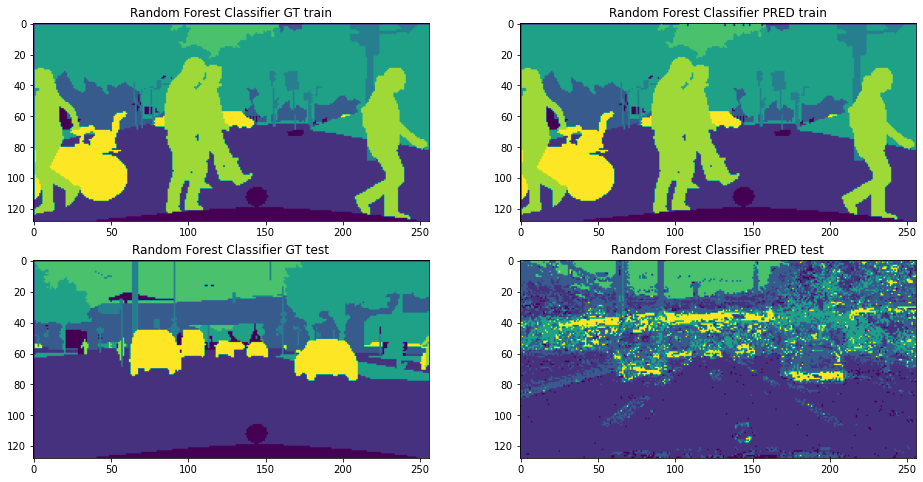

In [8]:
plt.figure(figsize=(16,8))

plt.subplot(221)
plt.imshow(np.reshape(Y_train.to_numpy().reshape(-1)[0:32768],(128,256)))
plt.title('Random Forest Classifier GT train')
plt.subplot(222)
plt.imshow(np.reshape(pred_train[0:32768],(128,256)))
plt.title('Random Forest Classifier PRED train')

plt.subplot(223)
plt.imshow(np.reshape(Y_test.to_numpy().reshape(-1)[0:32768],(128,256)))
plt.title('Random Forest Classifier GT test')
plt.subplot(224)
plt.imshow(np.reshape(pred_test[0:32768],(128,256)))
plt.title('Random Forest Classifier PRED test')

plt.show()

### Linear SVC

In [19]:
from sklearn.svm import LinearSVC
model = LinearSVC(dual=False ,C=10, tol=1e-4)  #Default of 100 is not converging
start = time.time()
model.fit(X_train, Y_train.values.ravel())
print('fit random forest classifier en', (time.time()-start)/60, 'minutes')

fit random forest classifier en 10.433982173601786 minutes


In [23]:
from sklearn import metrics
#Print the prediction accuracy
pred_train=model.predict(X_train)
pred_test=model.predict(X_test)

In [24]:
#First check the accuracy on training data. This will be higher than test data prediction accuracy.
print ("Accuracy on training data = ", metrics.accuracy_score(Y_train.values.ravel(), pred_train))
print ("Jaccard-micro/global - IoU on training data = ", metrics.jaccard_score(Y_train.values.ravel(), pred_train, average='micro'))
print ("Jaccard-macro/unweighted - IoU on training data = ", metrics.jaccard_score(Y_train.values.ravel(), pred_train, average='macro'))
print ("Jaccard-weighted - IoU on training data = ", metrics.jaccard_score(Y_train.values.ravel(), pred_train, average='weighted'))
print ("f1 score-micro/global - Dice on training data = ", metrics.f1_score(Y_train.values.ravel(), pred_train, average='micro'))
print ("f1 score-macro/unweighted - Dice on training data = ", metrics.f1_score(Y_train.values.ravel(), pred_train, average='macro'))
print ("f1 score-weighted - Dice on training data = ", metrics.f1_score(Y_train.values.ravel(), pred_train, average='weighted'))
#Check accuracy on test dataset. If this is too low compared to train it indicates overfitting on training data.
print ("Accuracy on test data = ", metrics.accuracy_score(Y_test.values.ravel(), pred_test))
print ("Jaccard-micro/global - IoU on test data = ", metrics.jaccard_score(Y_test.values.ravel(), pred_test, average='micro'))
print ("Jaccard-macro/unweighted - IoU on test data = ", metrics.jaccard_score(Y_test.values.ravel(), pred_test, average='macro'))
print ("Jaccard-weighted - IoU on test data = ", metrics.jaccard_score(Y_test.values.ravel(), pred_test, average='weighted'))
print ("f1 score-micro/global - Dice on test data = ", metrics.f1_score(Y_test.values.ravel(), pred_test, average='micro'))
print ("f1 score-macro/unweighted - Dice on test data = ", metrics.f1_score(Y_test.values.ravel(), pred_test, average='macro'))
print ("f1 score-weighted - Dice on test data = ", metrics.f1_score(Y_test.values.ravel(), pred_test, average='weighted'))

Accuracy on training data =  0.45895721435546877
Jaccard-micro/global - IoU on training data =  0.29782249956383455
Jaccard-macro/unweighted - IoU on training data =  0.15758558550413176
Jaccard-weighted - IoU on training data =  0.2512110611049861
f1 score-micro/global - Dice on training data =  0.45895721435546877
f1 score-macro/unweighted - Dice on training data =  0.2318122003341469
f1 score-weighted - Dice on training data =  0.36631407677171923
Accuracy on test data =  0.48354034423828124
Jaccard-micro/global - IoU on test data =  0.3188613309962398
Jaccard-macro/unweighted - IoU on test data =  0.16722093962156126
Jaccard-weighted - IoU on test data =  0.27214708111116204
f1 score-micro/global - Dice on test data =  0.48354034423828124
f1 score-macro/unweighted - Dice on test data =  0.23902126990017483
f1 score-weighted - Dice on test data =  0.3896900019492801


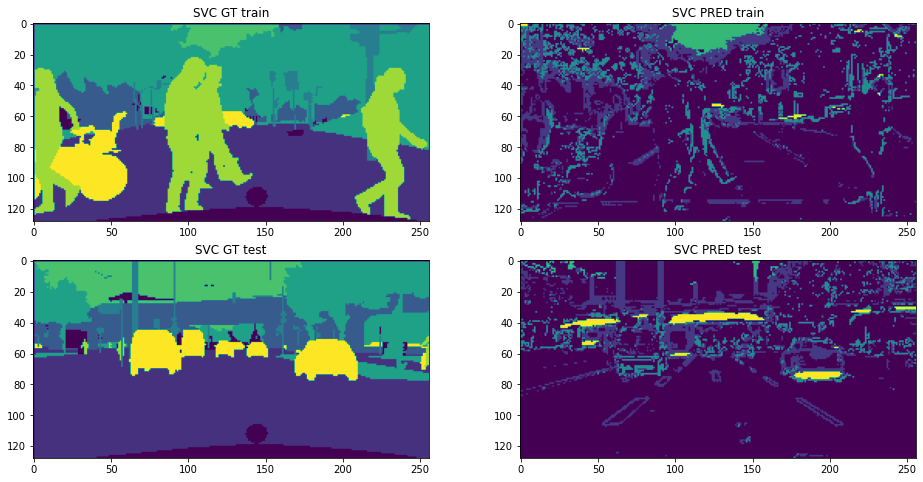

In [25]:
plt.figure(figsize=(16,8))

plt.subplot(221)
plt.imshow(np.reshape(Y_train.to_numpy().reshape(-1)[0:32768],(128,256)))
plt.title('SVC GT train')
plt.subplot(222)
plt.imshow(np.reshape(pred_train[0:32768],(128,256)))
plt.title('SVC PRED train')

plt.subplot(223)
plt.imshow(np.reshape(Y_test.to_numpy().reshape(-1)[0:32768],(128,256)))
plt.title('SVC GT test')
plt.subplot(224)
plt.imshow(np.reshape(pred_test[0:32768],(128,256)))
plt.title('SVC PRED test')

plt.show()